In [1]:
import numpy as np
import xarray as xr
import os
import xarray as xr
import pandas as pd
# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from scipy import signal
import h5py
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import ecco_v4_py as ecco

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

%matplotlib inline


In [10]:
# Define main directory
base_dir = '/Users/jacoposala/Downloads/'
data_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/OISSTv2/DATA/'
plot_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/trend_plots/'

In [11]:
# Define useful parameters
start_year = '1992' #1993
end_year = '2017' #2016


In [12]:
# # Map of the selected box

# # Define the coordinates of the four points
# lon_start_plot = lon_start - 360
# lon_end_plot = lon_end - 360

# # Create a Basemap instance with a global projection
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)

# # Create a figure and axes
# fig, ax = plt.subplots(figsize=(20, 6))

# # Set a background color
# ax.set_facecolor('lightblue')

# # Draw coastlines, countries, and fill continents
# m.drawcoastlines(linewidth=0.5)
# m.drawcountries(linewidth=0.5)
# m.fillcontinents(color='lightgray')

# # Draw the box
# lons = [lon_start_plot, lon_end_plot, lon_end_plot, lon_start_plot, lon_start_plot]
# lats = [lat_start, lat_start, lat_end, lat_end, lat_start]
# x, y = m(lons, lats)
# m.plot(x, y, color='red', linewidth=2)

# # Add grid lines
# m.drawparallels(np.arange(-90., 91., 20.), labels=[1, 0, 0, 0], linewidth=0.2, color='gray', fontsize = 14)
# m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1], linewidth=0.2, color='gray', fontsize = 14)

# # Show the plot
# plt.tight_layout()
# # plt.savefig('Map_box.pdf', bbox_inches='tight')


### Open dataset

In [13]:
# Open the main dataset
ds = xr.open_dataset(data_dir + 'sst.mon.mean.nc')

# Select the time range from start_year to end_year
ds_sel = ds.sel(time=slice(start_year, end_year))

# Open the long-term mean (ltm) dataset
ds_ltm = xr.open_dataset(data_dir + 'sst.day.mean.ltm.1991-2020.nc')


### Map of SST trend globally

In [14]:
# degrees per timestep
def trend_along_dim_as_change_per_timestep(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return (fit[-1]-fit[0])/len(da[dim])


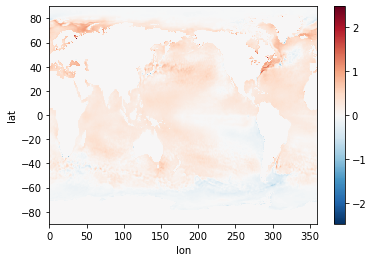

In [15]:
trend = trend_along_dim_as_change_per_timestep(da = ds_sel.sst, dim = 'time', deg=1)

number_timestep_per_year = 12
# number_timestep_per_year = 365

trend_decade = trend*10*number_timestep_per_year

trend_decade.plot()


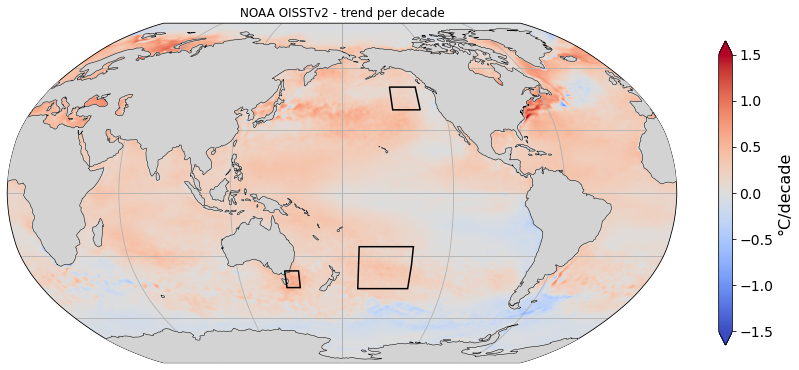

In [19]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

plot_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/trend_plots/'
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# Plot the trend data and get the colorbar
plot = trend_decade.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1.5, vmax=1.5, cbar_kwargs={'shrink': 0.7, 'label': '°C/decade'})

# Access the colorbar from the plot object and adjust the fontsize
cbar = plot.colorbar
cbar.ax.tick_params(labelsize=14)  # Adjust the fontsize of the colorbar ticks

# Adjust the fontsize of the colorbar label
cbar.set_label('°C/decade', fontsize=16)  # Adjust the fontsize of the colorbar label

# Add filled continents
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=100)

# Add coastlines
ax.coastlines(linewidth=0.5, zorder=999)

# Add gridlines
ax.gridlines(draw_labels=False)

# Define regions for plotting
regions_condition_list = [
    {"lon_min":147, "lon_max":155, "lat_min":-45, "lat_max":-37, "region_name":'TASMAN'},
    {"lon_min":-170.5, "lon_max":-140.5, "lat_min":-45.5, "lat_max":-25.5, "region_name":'SWP'},
    {"lon_min":-150.5, "lon_max":-134.5, "lat_min":39.5, "lat_max":50.5, "region_name":'NEP'}
]

# Plot each region box
for region in regions_condition_list:
    lon_start, lon_end = region["lon_min"], region["lon_max"]
    lat_start, lat_end = region["lat_min"], region["lat_max"]
    
    box = plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                        fill=False, edgecolor='black', linewidth=1.5, transform=ccrs.PlateCarree(), zorder=999)
    ax.add_patch(box)

# Remove title and other words from the plot
ax.set_title('NOAA OISSTv2 - trend per decade')
ax.set_xlabel('')
ax.set_ylabel('')

# Save the plot
plt.tight_layout()
plt.savefig(plot_dir + f'OISSTv2_trend_decade_map_{start_year}_{end_year}.png', dpi=1000, bbox_inches='tight')


In [9]:
# OLD WAY TO CALCULATE TREND
# # Extract the sst variable from the ds_sel Dataset
# sst = ds_sel['sst']

# # Convert time values to numeric values
# time_numeric = mdates.date2num(ds_sel['time'].to_index())

# # Calculate the linear trend for each lat and lon
# trend = xr.full_like(sst.isel(time=0), np.nan)  # Create an empty array for trends

# valid_mask = np.isnan(sst).sum(axis=0) == 0  # Mask of valid values

# for i_lat in range(sst.shape[1]):
#     for i_lon in range(sst.shape[2]):
#         if valid_mask[i_lat, i_lon]:
#             linear_trend = np.polyval(np.polyfit(time_numeric, sst[:, i_lat, i_lon], deg=1), time_numeric)
#             # Calculate the difference between the earliest and latest values
#             trend[i_lat, i_lon] = linear_trend[-1] - linear_trend[0]
        
# # Convert trend to change/decade
# # Divide by number of years in data set, and multiply by ten
# trend_decade = trend/(ds_sel.time.shape[0]/12)*10


# ECCO monthly

In [3]:
# ecco_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/heatBudgetECCO_jupyter/heat_nc_files_for_donata/'
ecco_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/heatBudgetECCO_jupyter/heat_nc_MONTHLY_files_for_donata/'
# dataset_ecco = xr.open_dataset(ecco_dir + 'ECCOv4r4_DATA_1993_2017.nc') # it actually includes 1993-2016
dataset_ecco = xr.open_dataset(ecco_dir + 'ECCOv4r4_DATA_1992_2017.nc') # it actually includes 1993-2016


In [4]:
load_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/metadata_ecco/'
# Load metadata
ECCO_metadata = ['XC_lon', 'YC_lat', 'Z_depth', 'vol', 'area']

# Create a dictionary to store the variables
ecco_data = {}
for ivar in ECCO_metadata:
    file_path = f"{load_path}/ECCOv4r4_{ivar}_1993_2017.nc"
    # Open the dataset and store it in the dictionary
    ecco_data[ivar] = xr.open_dataset(file_path)
    
# Access the variables using the dictionary
XC_lon = ecco_data['XC_lon']
YC_lat = ecco_data['YC_lat']
Z_depth = ecco_data['Z_depth']
vol = ecco_data['vol']
area = ecco_data['area']

ds_grid = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/eccov4r4_grid/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')


In [5]:
# Keep only the first k level
dataset_ecco_cut = dataset_ecco.DATA.isel(k=0)

In [6]:
# Initialize an empty list to store DataArray objects
field_nearest_1deg_times = []

new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

for t in range(len(dataset_ecco_cut['time'])):
#     print(t)
    new_grid_lon_centers, new_grid_lat_centers,\
    new_grid_lon_edges, new_grid_lat_edges,\
    field_nearest_1deg =\
            ecco.resample_to_latlon(ds_grid.XC, \
                                    ds_grid.YC, \
                                    dataset_ecco_cut.isel(time=t),\
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    # Convert the NumPy array to DataArray and append to the list
    field_nearest_1deg_times.append(xr.DataArray(field_nearest_1deg, dims=['lat', 'lon']))

# Concatenate the DataArray objects along the time dimension
field_nearest_1deg_all_times = xr.concat(field_nearest_1deg_times, dim='time')

field_nearest_1deg_all_times['time'] = dataset_ecco_cut['time']  


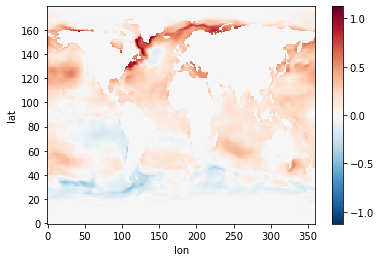

In [7]:
trend = trend_along_dim_as_change_per_timestep(da = field_nearest_1deg_all_times, dim = 'time', deg=1)

number_timestep_per_year = 12
# number_timestep_per_year = 365

trend_decade = trend*10*number_timestep_per_year

trend_decade.plot()

In [8]:
trend_decade['lat'] = trend_decade['lat'] - 90
# trend_decade['lat']

trend_decade['lon'] = trend_decade['lon'] - 180
# trend_decade['lon']

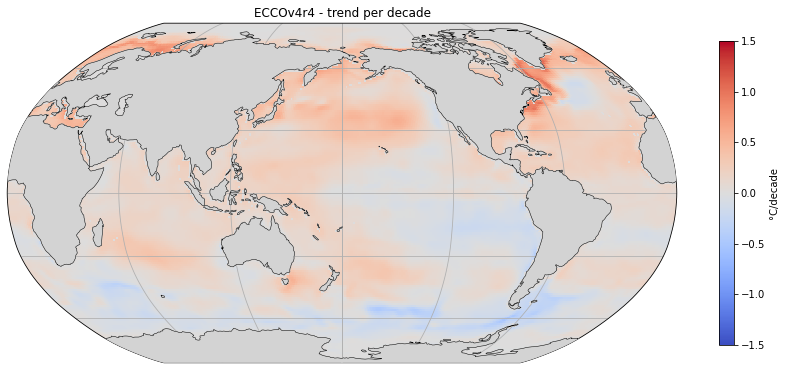

In [9]:
plot_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/trend_plots/'
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.Robinson(central_longitude = -180))

# Plot the trend data
trend_decade.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1.5, vmax=1.5, cbar_kwargs={'shrink': 0.7, 'label': '°C/decade'})
# cbar = plt.colorbar(plot)
# Add filled continents
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=100)

# Add coastlines
ax.coastlines(linewidth=0.5, zorder=999)

# Add gridlines
ax.gridlines(draw_labels=False)

# Remove title and other words from the plot
ax.set_title('ECCOv4r4 - trend per decade')

# Save the plot
plt.tight_layout()
plt.savefig(plot_dir + 'ECCOv4r4_monthly_trend_decade_map_1992_2017.png', dpi=1000, bbox_inches='tight')


In [17]:
ciao

NameError: name 'ciao' is not defined

# Argo monhtly

In [5]:
argo_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/GCOS_Global_2004_2022_15_50/Results/FullField/'



In [6]:
from scipy.io import loadmat

# Load the .mat file
mat_file = loadmat(argo_dir + 'intTempFullFieldSpaceTimeTrend_15_50_01_2004.mat')

# Access the variables stored in the .mat file
# For example, if there is a variable named 'data' in the .mat file
argo_data = mat_file['fullFieldGrid']

In [7]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Nov 21 00:32:21 2023',
 '__version__': '1.0',
 '__globals__': [],
 'fullFieldGrid': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [ ]:
all_data = []

# Loop through years and months
for year in range(2004, 2023):  # 2023 is exclusive
    for month in range(1, 13):  # 1 to 12
        # Generate the filename based on the year and month
        filename = f'intTempFullFieldSpaceTimeTrend_15_50_{month:02d}_{year}.mat'
        filepath = os.path.join(argo_dir, filename)
        
        # Check if the file exists
        if os.path.isfile(filepath):
            # Load the .mat file
            mat_file = loadmat(filepath)
            
            # Access the data variable and append to all_data
            data = mat_file['fullFieldGrid']
            all_data.append(data)

concatenated_argo_data = np.stack(all_data, axis=-1)
# concatenated_data.shape # (360, 180, 228) lon, lat, time (month)

In [ ]:
import xarray as xr
import numpy as np

# Assuming concatenated_argo_data is your concatenated Argo data with shape (360, 180, 228)

# Generate coordinate arrays for lon, lat, and time
lon = np.arange(-179.5, 180.5, 1)  # Example for longitude
lat = np.arange(-89.5, 90.5, 1)  # Example for latitude
time = np.arange(228)  # Example for time

# Create the xarray DataArray
argo_data_array = xr.DataArray(concatenated_argo_data,
                               dims=('lon', 'lat', 'time'),
                               coords={'lon': lon,
                                       'lat': lat,
                                       'time': time})

# Optionally, you can set attributes to provide additional metadata
argo_data_array.attrs['long_name'] = 'Argo OHC'
argo_data_array.attrs['units'] = 'Some unit'


In [ ]:
argo_data_array.sel(time=0).plot(x='lon', y='lat')


In [ ]:
trend = trend_along_dim_as_change_per_timestep(da = argo_data_array, dim = 'time', deg=1)

number_timestep_per_year = 12
# number_timestep_per_year = 365

trend_decade = trend*10*number_timestep_per_year

trend_decade.T.plot()

In [ ]:
trend_decade.plot()

In [ ]:
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.Robinson(central_longitude = -180))

# Plot the trend data
trend_decade.T.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'shrink': 0.7, 'label': '°C'})
# cbar = plt.colorbar(plot)
# Add filled continents
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=100)

# Add coastlines
ax.coastlines(linewidth=0.5, zorder=999)

# Add gridlines
ax.gridlines(draw_labels=False)

# Remove title and other words from the plot
ax.set_title('ECCOv4r4 - trend per decade')

# Save the plot
plt.tight_layout()
# plt.savefig(plot_dir + 'Argo_monthly_OHC_trend_decade_map.png', dpi=1000, bbox_inches='tight')


# Schematic percentile

In [4]:
# file_path = '/Users/jacoposala/Downloads/Blanca_Outputs/oisst_v2_monthly_temp_oisst_1993_2016/output/figures/oisst_v2_1993_2016_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'
file_path = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_heat_daily_temp_ohc_k0_k5_2004_2016/output/figures/ECCOv4r4_heat_daily_2004_2016_prcnt90_noTrend_minLen_5tsteps_withAVE.mat'

# Load the data selected above
mat_data = h5py.File(file_path, 'r')

# List the keys in the file
# print("Keys in the file:", list(mat_data.keys()))

# Access the data under the key '#refs#'
refs_data = mat_data['#refs#']

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data = mat_data['find_MHWs_info']


In [5]:
find_mhws_info_data.keys()


<KeysViewHDF5 ['G_advection_declineAve', 'G_advection_eventAve', 'G_advection_onsetAve', 'G_diffusion_declineAve', 'G_diffusion_eventAve', 'G_diffusion_onsetAve', 'G_forcing_declineAve', 'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_total_declineAve', 'G_total_eventAve', 'G_total_onsetAve', 'adv_vConv_declineAve', 'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'data_mhw_tstep_msk', 'data_percentile3d', 'data_used4MHWs', 'data_used4MHWs_declineAve', 'data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'delta_tstep', 'dif_vConv_declineAve', 'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'end_tstep', 'end_tstep_stored_at_peak', 'events_duration_in_tsteps', 'events_number', 'flag_remove_trend', 'onset_duration_in_tsteps', 'peak_tstep', 'peak_tstep_msk', 'peak_value', 'percentile', 'start_tstep', 'start_tstep_msk', 'years']>

In [6]:
data_used4MHWs = find_mhws_info_data['data_used4MHWs'].value
data_percentile3d = find_mhws_info_data['data_percentile3d'].value

In [7]:
data_used4MHWs.shape

(4749, 13, 8100)

In [8]:
from datetime import datetime, timedelta

# Initialize the start and end dates
start_date = datetime(1993, 1, 1)
end_date = datetime(2016, 12, 1)

# Initialize an empty list to hold the months
months = []

# Iterate through each month from the start date to the end date
current_date = start_date
while current_date <= end_date:
    # Format the current date as "MMM YYYY" and append to the list
    months.append(current_date.strftime("%b %Y"))
    # Move to the next month
    next_month = current_date.month % 12 + 1
    next_year = current_date.year + (current_date.month // 12)
    current_date = datetime(next_year, next_month, 1)

# Print the list of months
print(months)


['Jan 1993', 'Feb 1993', 'Mar 1993', 'Apr 1993', 'May 1993', 'Jun 1993', 'Jul 1993', 'Aug 1993', 'Sep 1993', 'Oct 1993', 'Nov 1993', 'Dec 1993', 'Jan 1994', 'Feb 1994', 'Mar 1994', 'Apr 1994', 'May 1994', 'Jun 1994', 'Jul 1994', 'Aug 1994', 'Sep 1994', 'Oct 1994', 'Nov 1994', 'Dec 1994', 'Jan 1995', 'Feb 1995', 'Mar 1995', 'Apr 1995', 'May 1995', 'Jun 1995', 'Jul 1995', 'Aug 1995', 'Sep 1995', 'Oct 1995', 'Nov 1995', 'Dec 1995', 'Jan 1996', 'Feb 1996', 'Mar 1996', 'Apr 1996', 'May 1996', 'Jun 1996', 'Jul 1996', 'Aug 1996', 'Sep 1996', 'Oct 1996', 'Nov 1996', 'Dec 1996', 'Jan 1997', 'Feb 1997', 'Mar 1997', 'Apr 1997', 'May 1997', 'Jun 1997', 'Jul 1997', 'Aug 1997', 'Sep 1997', 'Oct 1997', 'Nov 1997', 'Dec 1997', 'Jan 1998', 'Feb 1998', 'Mar 1998', 'Apr 1998', 'May 1998', 'Jun 1998', 'Jul 1998', 'Aug 1998', 'Sep 1998', 'Oct 1998', 'Nov 1998', 'Dec 1998', 'Jan 1999', 'Feb 1999', 'Mar 1999', 'Apr 1999', 'May 1999', 'Jun 1999', 'Jul 1999', 'Aug 1999', 'Sep 1999', 'Oct 1999', 'Nov 1999', 'De

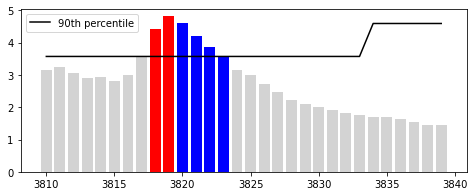

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming months, data_used4MHWs, and data_percentile3d are already defined

# Create the figure with the specified size
plt.figure(figsize=(8, 3))

# Define the range of indices to be plotted
start_index = 3810
end_index = 3840

# Extract the relevant data for the specified range
data_used = data_used4MHWs[start_index:end_index, 0, 3600]
data_percentile = data_percentile3d[start_index:end_index, 0, 3600]

# Generate the x positions for the bars
x_positions = np.arange(start_index, end_index)

# Determine the colors based on the comparison and the trend
colors = []
for i in range(len(data_used)):
    if data_used[i] > data_percentile[i]:
        if i == 0 or data_used[i] > data_used[i - 1]:
            colors.append('red')
        elif i > 0 and data_used[i] < data_used[i - 1]:
            colors.append('blue')
        else:
            colors.append('lightgrey')
    else:
        colors.append('lightgrey')

# Create the bar plot
plt.bar(x_positions, data_used, color=colors)

# Overlay the line plot for data_percentile
plt.plot(x_positions, data_percentile, color='black', label='90th percentile')

# Optionally, set the x-ticks to be the corresponding months
# xticks_labels = months[start_index:end_index]
# plt.xticks(x_positions, xticks_labels, rotation=45)

# # Add labels and title to the plot
# plt.xlabel('Month')
# plt.ylabel('Data Value')
# plt.title('Data Plot with Conditional Coloring and Percentile Line')

# Add a legend to the plot
plt.legend()

# Show the plot
# plt.show()
plt.savefig('percentile_square.png', dpi=1000)


In [87]:
# CHECK AND FIND TIMESTEP WITH VALUES

# Step 1: Create a boolean mask where NaNs are marked as True
mask = np.isnan(data_used4MHWs)

# Step 2: Find indices where mask is False
valid_indices = np.argwhere(~mask)

# Step 3: Select one of these indices
if valid_indices.size > 0:
    selected_index = valid_indices[0]  # Selecting the first valid index
    value = data_used4MHWs[tuple(selected_index)]  # Getting the value at this index
    print(f"Selected index: {selected_index}, Value: {value}")
else:
    print("No valid data points found in the array.")

Selected index: [   0    0 3600], Value: -0.8488356299759865


# Data percentile 3d maps

## OISST

In [ ]:
# Load the data selected above
# load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/OISST_1993_2016/output/figures/'
file_path = '/Users/jacoposala/Downloads/Blanca_Outputs/oisst_v2_monthly_temp_oisst_1993_2016/output/figures/oisst_v2_1993_2016_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'
mat_data = h5py.File(file_path, 'r')

# List the keys in the file
# print("Keys in the file:", list(mat_data.keys()))

# Access the data under the key '#refs#'
refs_data = mat_data['#refs#']

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data = mat_data['find_MHWs_info']

find_mhws_info_data.keys()

data_percentile3d = find_mhws_info_data['data_percentile3d'].value


In [ ]:
data_percentile3d.shape #(288, 720, 1440) (time, lat, lon) 1/4 deg resolution


In [ ]:
find_mhws_info_data['data_used4MHWs_eventAve']

In [ ]:
find_mhws_info_data.keys()


In [ ]:
data_percentile3d_mean_time = data_percentile3d.mean(axis=0)

In [ ]:
plt.scatter(np.arange(0,720,1), np.arange(0,1440,1), (data_percentile3d_mean_time))

In [ ]:
data_percentile3d_mean_time.shape

### Calculate anomalies (SST without the monthly component, from the long-term data file)

In [ ]:
# Create month variable
ds_ltm['month'] = ds_ltm['time.month']

# Group the long-term dataset by 'month' and calculate the mean
# i.e., 12 values for each lat,lon 
monthly_means = ds_ltm.groupby('month').mean(dim='time')

In [ ]:
# Calculate monthly anomalies in the actual data set, with respect to the long-term mean
sst_anom = ds_sel.sst.groupby('time.month') - monthly_means['sst']

In [ ]:
# Add variable to main xarray
ds_sel["sst_anom"]=(['time', 'lat', 'lon'],  sst_anom.values)

### Remove the long-term trend

In [ ]:
# Remove trend from anomalies
# Using least-square implemented in signal.detrend
# Which does not work if NaNs are present, so set them to zero first, and then replace them again at the end
# De-trend is removed for each location's time series (axis = 0 in command below),
# so this should have no impact, since NaNs are either always present (land) or never present (ocean) at a given location
sst_anom_numpy = sst_anom.values

where_are_nans = np.isnan(sst_anom_numpy)
sst_anom_numpy[where_are_nans] = 0

# De-trend
sst_anom_detrend = signal.detrend(sst_anom_numpy, axis=0)

# Replacing detrended array's zeros back with nans
sst_anom_detrend[sst_anom_detrend == 0] = np.nan


In [ ]:
# Add detrended data to main xarray
ds_sel["sst_anom_detrended"]=(['time', 'lat', 'lon'],  sst_anom_detrend)

### Global map of de-trended anomalies for selected time stamps

In [ ]:
# Define the start and end dates of the desired time range
start_date = '2010-01-01'
end_date = '2011-12-01'

# Generate a list of dates between the start and end dates
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

In [ ]:

for i in date_range:
    # Extract the latitude and longitude coordinates
#     lats = data['lat'].values
#     lons = data['lon'].values

    # Create a figure and axes
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

    # Plot the data
    ds_sel.sel(time=i).sst_anom_detrended.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-2, vmax=2, cbar_kwargs={'shrink': 0.8})

    # Add filled continents
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha = 0.7)
    # Add coastlines
    ax.coastlines(linewidth=0.5)

    # Add gridlines
    ax.gridlines(draw_labels=False, xlocs=range(-180, 180, 45), ylocs=range(-90, 91, 45))

    # Add a black, unfilled box
    box = plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                        fill=False, edgecolor='black', linewidth=1.5, transform=ccrs.PlateCarree(), zorder = 999)
    ax.add_patch(box)

    # Extract the year and month from the current date
    date_str = i.strftime("%Y-%m")

    # Add the year and month to the title
    ax.set_title('SST Anomaly - {}'.format(date_str))
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Save the plot
    plt.tight_layout()
    plt.savefig('SST_anom_map_{}'.format(date_str) + '.png', dpi = 600, bbox_inches='tight')
    

### Calculate horizontal average over a region

In [ ]:
if horizontal_avg_tag:

    # Select the region of interest using the coordinates
    subset = ds_sel.sel(lat = slice(lat_start, lat_end), lon = slice(lon_start, lon_end))

    # Calculate the horizontal average
    ds_sel = subset.mean(dim=['lat', 'lon'])

    # Calculate the center coordinates
    lat_center = (lat_start + lat_end) / 2
    lon_center = (lon_start + lon_end) / 2

    # Assign 'lat' and 'lon' as new coordinates
    ds_sel = ds_sel.assign_coords(lat=lat_center, lon=lon_center)

    # Save the DataArray to a file
    # average_dataarray.to_netcdf('average_with_coords.nc')


### Time series of SST anomalies (with trend)

In [ ]:
if horizontal_avg_tag:
    # Convert time values to numeric values
    time_numeric = mdates.date2num(ds_sel.time.to_index())

    # Calculate the linear trend
    sst_anom = ds_sel.sst_anom
    trend = np.polyfit(time_numeric, sst_anom, deg=1)
    linear_trend = np.polyval(trend, time_numeric)

    # Plotting the time series line plot with linear trend
    plt.figure(figsize=(15, 6))
    plt.plot(ds_sel.time, sst_anom, label='SST Anomalies')
    plt.plot(ds_sel.time, linear_trend, color='red', linewidth=2, label='Linear Trend')
    #plt.title('Sea Surface Temperature Anomalies Time Series with Linear Trend', fontsize = 14)
    plt.xlabel('Time', fontsize = 20)
    plt.ylabel('SST Anomaly ($\degree$C)', fontsize = 20)
    plt.grid(True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20)
    plt.tight_layout()
    plt.savefig('TimeSeries_boxavg.pdf')

    # How much is the trend between 2023 and 1991?
    print(linear_trend[-1]-linear_trend[0])

### Calculate percentiles, for both detrended and not-detrended data

In [ ]:
# Calculate percentile thresholds to define MHWs

list_months = pd.date_range(ds_sel.time[0].values, ds_sel.time[-1].values, freq='1M') - pd.offsets.MonthBegin(1)

# Initialize variables to store percentiles
if horizontal_avg_tag:
    perc_90 = np.zeros((12,1,1))
    perc_95 = np.zeros((12,1,1))
    perc_99 = np.zeros((12,1,1))
    perc_90_detrended = np.zeros((12,1,1))
    perc_95_detrended = np.zeros((12,1,1))
    perc_99_detrended = np.zeros((12,1,1))
else:
    perc_90 = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))
    perc_95 = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))
    perc_99 = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))
    perc_90_detrended = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))
    perc_95_detrended = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))
    perc_99_detrended = np.zeros((12,ds_sel.lat.shape[0],ds_sel.lon.shape[0]))

for imonth in np.arange(12): # loop over each calendar month
    # Find indexes of months for 3-month window
    month_current = imonth + 1 # imonths starts at 0...
    month_before = imonth
    
    if month_before < 1:
        month_before = 12
    month_after = imonth + 2
    if month_after > 12:
        month_after = 1
    # Extract data on a 3-month window (at all locations)
    data_window = ds_sel.sel(time = ((ds_sel['time.month'] == month_before) | \
                                          (ds_sel['time.month'] == month_current) | \
                                          (ds_sel['time.month'] == month_after)))

    # Calculate percentiles at each location, over the 3-month window time series
    perc_90[imonth,:,:] = np.percentile(data_window.sst_anom.values, 90, axis = 0)
    perc_95[imonth,:,:] = np.percentile(data_window.sst_anom.values, 95, axis = 0)
    perc_99[imonth,:,:] = np.percentile(data_window.sst_anom.values, 99, axis = 0)
    # Now again, for de-trended anomalies
    perc_90_detrended[imonth,:,:] = np.percentile(data_window.sst_anom_detrended.values, 90, axis = 0)
    perc_95_detrended[imonth,:,:] = np.percentile(data_window.sst_anom_detrended.values, 95, axis = 0)
    perc_99_detrended[imonth,:,:] = np.percentile(data_window.sst_anom_detrended.values, 99, axis = 0)
    

### Bar plots

In [ ]:
if horizontal_avg_tag:
    lat_plot_list = [ds_sel['lat'].item()]
    lon_plot_list = [ds_sel['lon'].item()]

In [ ]:
plt.close()

In [ ]:
# DATA WITH TREND

for lat_sel, lon_sel in zip(lat_plot_list, lon_plot_list):
    # Data to plot
    if horizontal_avg_tag:
        time_series = ds_sel["sst_anom"][:].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(np.ravel(perc_90), int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(np.ravel(perc_95), int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(np.ravel(perc_99), int(end_year) - int(start_year) +1)
    else:
        # Find lat, lon indexes closest to lat, lon values
        # Calculate the squared differences between the target coordinates and the DataArray coordinates
        lat_diff = np.abs(ds_sel['lat'] - lat_sel)
        lon_diff = np.abs(ds_sel['lon'] - lon_sel)
        # Find the indexes of the minimum distance
        ilat = lat_diff.argmin()
        ilon = lon_diff.argmin()
        # Extract data at desired location
        time_series = ds_sel["sst_anom"][:, ilat, ilon].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(perc_90[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(perc_95[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(perc_99[:,ilat,ilon], int(end_year) - int(start_year) +1)

    # Create the bar plot using different colors based on percentiles
    fig, ax = plt.subplots(figsize = (15,6))
    bars = ax.bar(ds_sel.time.values, time_series, align='center', width = 2*10**15)
    ax.xaxis_date()

    # Assign colors to the bars based on their percentile
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('lightgray')
        elif bar.get_height() < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)
    for i, bar in enumerate(bars):
        if time_series[i] > perc_99_plot[i]:
            bar.set_color('red')
            index_99 = i
        elif time_series[i] > perc_95_plot[i]:
            bar.set_color('orange')
            index_95 = i
        elif time_series[i] > perc_90_plot[i]:
            bar.set_color('yellow')
            index_90 = i

    # Add labels and title
    plt.xlabel('Time', fontsize = 20)
    plt.ylabel('Mean SST Anomaly ($\degree$C)', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    plt.ylim([-1.5,1.5])
    
    # Add a legend for color coding
    percentiles = {'90', '95', '99'}
    legend_labels = [f'>{p}th percentile' for p in sorted(percentiles)]
    plt.legend([bars[index_90],bars[index_95],bars[index_99]], legend_labels, loc = 'lower right', fontsize = 15)

    # Which lat did we plot?
    if horizontal_avg_tag == False:
        print('Latitude being considered: ', ds_sel["lat"][ilat].values)
        print('Longitude being considered: ', ds_sel["lon"][ilon].values)
        
    plt.tight_layout()
    plt.savefig('MHW_trend.png', dpi = 600)


In [ ]:
# DE-TRENDED DATA

for lat_sel, lon_sel in zip(lat_plot_list, lon_plot_list):
    # Data to plot
    if horizontal_avg_tag:
        time_series = ds_sel["sst_anom_detrended"][:].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(np.ravel(perc_90_detrended), int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(np.ravel(perc_95_detrended), int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(np.ravel(perc_99_detrended), int(end_year) - int(start_year) +1)
    else:
        # Find lat, lon indexes closest to lat, lon values
        # Calculate the squared differences between the target coordinates and the DataArray coordinates
        lat_diff = np.abs(ds_sel['lat'] - lat_sel)
        lon_diff = np.abs(ds_sel['lon'] - lon_sel)
        # Find the indexes of the minimum distance
        ilat = lat_diff.argmin()
        ilon = lon_diff.argmin()
        # Extract data at desired location
        time_series = ds_sel["sst_anom_detrended"][:, ilat, ilon].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(perc_90_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(perc_95_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(perc_99_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)

    # Create the bar plot using different colors based on percentiles
    fig, ax = plt.subplots(figsize = (15,6))
    bars = ax.bar(ds_sel.time.values, time_series, align='center', width = 2*10**15)
    ax.xaxis_date()

    # Assign colors to the bars based on their percentile
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('lightgray')
        elif bar.get_height() < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)
    for i, bar in enumerate(bars):
        if time_series[i] > perc_99_plot[i]:
            bar.set_color('red')
            index_99 = i
        elif time_series[i] > perc_95_plot[i]:
            bar.set_color('orange')
            index_95 = i
        elif time_series[i] > perc_90_plot[i]:
            bar.set_color('yellow')
            index_90 = i

    # Add labels and title
    plt.xlabel('Time', fontsize = 20)
    plt.ylabel('Mean SST Anomaly ($\degree$C)', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylim([-1.5,1.5])

    # Add a legend for color coding
    percentiles = {'90', '95', '99'}
    legend_labels = [f'>{p}th percentile' for p in sorted(percentiles)]
    plt.legend([bars[index_90],bars[index_95],bars[index_99]], legend_labels, loc = 'lower right', fontsize = 15)


    # Which lat did we plot?
    if horizontal_avg_tag == False:
        print('Latitude being considered: ', ds_sel["lat"][ilat].values)
        print('Longitude being considered: ', ds_sel["lon"][ilon].values)
        
    plt.tight_layout()
    plt.savefig('MHW_detrend.png', dpi = 600)
    

### Add ECCO tendency terms (G_total) to time series of SST MHW

In [ ]:
dataset = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/heatBudgetECCO_jupyter/test_-170.5_-140.5_-45.5_-25.5/G_total_-170.5_-140.5_-45.5_-25.5_box_wgt_area_avg_HEAT.nc')
dataset_anom = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/heatBudgetECCO_jupyter/test_-170.5_-140.5_-45.5_-25.5/G_total_anom_-170.5_-140.5_-45.5_-25.5_box_wgt_area_avg_HEAT.nc')
THETA_anom = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/heatBudgetECCO_jupyter/test_-170.5_-140.5_-45.5_-25.5/DATA_anom_box_wgt_area_avg_HEAT.nc')


In [ ]:
# Extract the time series data from "dataset" for the desired variable, at the level closest to the surface
ECCO_Gtot = dataset['data'].values[:,0]
ECCO_Gtot_anom = dataset_anom['G_total_anom_box_wgt_area_avg'].values[:,0]
ECCO_theta_anom = THETA_anom['DATA_anom_box_wgt_area_avg'].values[:,0]
ECCO_time = dataset.time.values

In [ ]:
# Shift to ~ beginninng of the month
ECCO_time = ECCO_time - np.timedelta64(16, 'D') - np.timedelta64(12, 'h')


In [ ]:
# DE-TRENDED DATA

for lat_sel, lon_sel in zip(lat_plot_list, lon_plot_list):
    # Data to plot
    if horizontal_avg_tag:
        time_series = ds_sel["sst_anom_detrended"][:].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(np.ravel(perc_90_detrended), int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(np.ravel(perc_95_detrended), int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(np.ravel(perc_99_detrended), int(end_year) - int(start_year) +1)
    else:
        # Find lat, lon indexes closest to lat, lon values
        # Calculate the squared differences between the target coordinates and the DataArray coordinates
        lat_diff = np.abs(ds_sel['lat'] - lat_sel)
        lon_diff = np.abs(ds_sel['lon'] - lon_sel)
        # Find the indexes of the minimum distance
        ilat = lat_diff.argmin()
        ilon = lon_diff.argmin()
        # Extract data at desired location
        time_series = ds_sel["sst_anom_detrended"][:, ilat, ilon].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(perc_90_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(perc_95_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(perc_99_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)

    # Create the bar plot using different colors based on percentiles
    fig, ax = plt.subplots(figsize = (15,6))
    bars = ax.bar(ds_sel.time.values, time_series, align='center', width = 2*10**15)
    bars_theta = ax.bar(ECCO_time, ECCO_theta_anom, align='center', width = 2*10**15, color='none', edgecolor='black', linewidth=0.2, alpha = 0.9)
    ax.xaxis_date()
    
    # Assign colors to the bars based on their percentile
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('lightgray')
        elif bar.get_height() < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)
    for i, bar in enumerate(bars):
        if time_series[i] > perc_99_plot[i]:
            bar.set_color('red')
            index_99 = i
        elif time_series[i] > perc_95_plot[i]:
            bar.set_color('orange')
            index_95 = i
        elif time_series[i] > perc_90_plot[i]:
            bar.set_color('yellow')
            index_90 = i

    # Add labels and title
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Mean SST Anomaly ($\degree$C)', fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim([-1.5, 1.5])
            
    # Add a legend for the line plot, bars, and bars_theta
    percentiles = {'90', '95', '99'}
    legend_labels = [f'>{p}th percentile' for p in sorted(percentiles)]
    combined_handles = [bars[index_90], bars[index_95], bars[index_99], bars_theta[0]]
    combined_labels = legend_labels + ['ECCO 5-m potential temperature']
    plt.legend(combined_handles, combined_labels, loc='lower right', fontsize=15)

    # Which lat did we plot?
    if horizontal_avg_tag == False:
        print('Latitude being considered: ', ds_sel["lat"][ilat].values)
        print('Longitude being considered: ', ds_sel["lon"][ilon].values)
        
    plt.tight_layout()
    plt.savefig('MHW_detrend_theta_anom.png', dpi = 600)
    

In [ ]:
# DE-TRENDED DATA

for lat_sel, lon_sel in zip(lat_plot_list, lon_plot_list):
    # Data to plot
    if horizontal_avg_tag:
        time_series = ds_sel["sst_anom_detrended"][:].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(np.ravel(perc_90_detrended), int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(np.ravel(perc_95_detrended), int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(np.ravel(perc_99_detrended), int(end_year) - int(start_year) +1)
    else:
        # Find lat, lon indexes closest to lat, lon values
        # Calculate the squared differences between the target coordinates and the DataArray coordinates
        lat_diff = np.abs(ds_sel['lat'] - lat_sel)
        lon_diff = np.abs(ds_sel['lon'] - lon_sel)
        # Find the indexes of the minimum distance
        ilat = lat_diff.argmin()
        ilon = lon_diff.argmin()
        # Extract data at desired location
        time_series = ds_sel["sst_anom_detrended"][:, ilat, ilon].values
        # From 12 values to 12 x number of years, to match time_series
        perc_90_plot = np.tile(perc_90_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_95_plot = np.tile(perc_95_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)
        perc_99_plot = np.tile(perc_99_detrended[:,ilat,ilon], int(end_year) - int(start_year) +1)

    # Create the bar plot using different colors based on percentiles
    fig, ax = plt.subplots(figsize = (15,6))
    bars = ax.bar(ds_sel.time.values, time_series, align='center', width = 2*10**15)
    bars_theta = ax.bar(ECCO_time, ECCO_theta_anom, align='center', width = 2*10**15, color='none', \
                        edgecolor='black', linewidth=0.1, alpha = 0.8)
    ax.xaxis_date()
    
    # Create a secondary y-axis
    ax2 = ax.twinx()

    # Plot the line data on the secondary y-axis
    ax2.plot(ECCO_time, ECCO_Gtot_anom, color='black')

    # Assign colors to the bars based on their percentile
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('lightgray')
        elif bar.get_height() < 0:
            bar.set_color('lightblue')
    for i, bar in enumerate(bars):
        if time_series[i] > perc_99_plot[i]:
            bar.set_color('red')
            index_99 = i
        elif time_series[i] > perc_95_plot[i]:
            bar.set_color('orange')
            index_95 = i
        elif time_series[i] > perc_90_plot[i]:
            bar.set_color('yellow')
            index_90 = i

    # Add labels and title
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Mean SST Anomaly ($\degree$C)', fontsize=20)
    ax2.set_ylabel('ECCO G_total anomaly', fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax2.tick_params(axis='both', labelsize=20)
    ax.set_ylim([-1.5, 1.5])
    ax2.set_ylim([min(ECCO_Gtot_anom), -min(ECCO_Gtot_anom)])
            
    # Add a legend for the line plot, bars, and bars_theta
    percentiles = {'90', '95', '99'}
    legend_labels = [f'>{p}th percentile' for p in sorted(percentiles)]
    combined_handles = [bars[index_90], bars[index_95], bars[index_99], bars_theta[0]]
    combined_labels = legend_labels + ['ECCO 5-m potential temperature']
    plt.legend(combined_handles, combined_labels, loc='lower right', fontsize=15)

    # Which lat did we plot?
    if horizontal_avg_tag == False:
        print('Latitude being considered: ', ds_sel["lat"][ilat].values)
        print('Longitude being considered: ', ds_sel["lon"][ilon].values)
        
    plt.tight_layout()
    plt.savefig('MHW_detrend_Gtotal_theta_anom.png', dpi = 600)
    